## Modeling - Classifying Book Cover by Decade Published (Binary - Pre 2010's and 2010's +)

#### This notebook was run in Google Colab

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(42)

In [ ]:
!unzip /content/drive/MyDrive/datasets/capstone/images.zip

In [3]:
train = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/train_2_cleaned.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/test_2_cleaned.csv', index_col=0)

In [ ]:
train.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade,post_2010
0,1588345297,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,Gus Lee,1,Biographies & Memoirs,"{""ISBN-13"": ""9781588345295"", ""Title"": ""With Sc...",2015,Gus Lee,2010,post_2010
1,1404803335,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books,"{""ISBN-13"": ""9781404803336"", ""Title"": ""Magnets...",2002,Natalie M. Rosinsky,2000,pre_2010
2,471310115,0471310115.jpg,"Janice VanCleave's 201 Awesome, Magical, Bizar...",Janice VanCleave,4,Children's Books,"{""ISBN-13"": ""9780471310112"", ""Title"": ""Janice ...",1994,Janice VanCleave,1990,pre_2010


In [ ]:
test.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade,post_2010
0,60750715,0060750715.jpg,George Balanchine: The Ballet Maker (Eminent L...,Robert Gottlieb,1,Biographies & Memoirs,"{""ISBN-13"": ""9780060750701"", ""Title"": ""George ...",2004,Robert Gottlieb,2000,pre_2010
1,312556411,0312556411.jpg,Literature and Its Writers: A Compact Introduc...,Ann Charters,15,Literature & Fiction,"{""ISBN-13"": ""9781457606472"", ""Title"": ""Literat...",2012,Ann Charters,2010,post_2010
2,545700272,0545700272.jpg,A Handful of Stars,Cynthia Lord,4,Children's Books,"{""ISBN-13"": ""9780545700283"", ""Title"": ""A Handf...",2017,Cynthia Lord,2010,post_2010


### Baseline Model

In [ ]:
train['post_2010'].value_counts(normalize=True)

post_2010    0.5957
pre_2010     0.4043
Name: post_2010, dtype: float64

> post_2010 includes the 2010s

### Basic CNN Model

In [4]:
datagen = ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(256,256)
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(256,256),
    shuffle=False
)

Found 9117 validated image filenames belonging to 2 classes.
Found 1023 validated image filenames belonging to 2 classes.


In [5]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_gen.classes), 
            y = train_gen.classes)

train_class_weights = dict(enumerate(class_weights))

In [6]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(
    optimizer ='adam',
    loss = 'bce',
    metrics = ['accuracy']
)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
)

In [8]:
history1 = model1.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 60s 149ms/step - loss: 0.7577 - accuracy: 0.5902 - val_loss: 0.6705 - val_accuracy: 0.5728
Epoch 2/100
285/285 [==============================] - 40s 140ms/step - loss: 0.6189 - accuracy: 0.6439 - val_loss: 0.6820 - val_accuracy: 0.5689
Epoch 3/100
285/285 [==============================] - 43s 151ms/step - loss: 0.4832 - accuracy: 0.7450 - val_loss: 0.6796 - val_accuracy: 0.6158
Epoch 4/100
285/285 [==============================] - 37s 129ms/step - loss: 0.2766 - accuracy: 0.8686 - val_loss: 0.9954 - val_accuracy: 0.6657
Epoch 5/100
285/285 [==============================] - 40s 139ms/step - loss: 0.1300 - accuracy: 0.9469 - val_loss: 1.3839 - val_accuracy: 0.6403
Epoch 6/100
285/285 [==============================] - 35s 122ms/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 2.0653 - val_accuracy: 0.6657
Epoch 6: early stopping


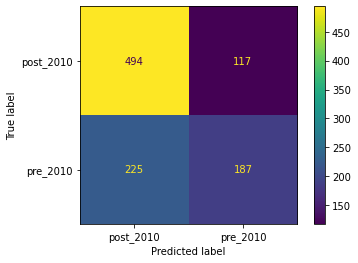

In [78]:
preds = model1.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(test_gen.class_indices.keys()));

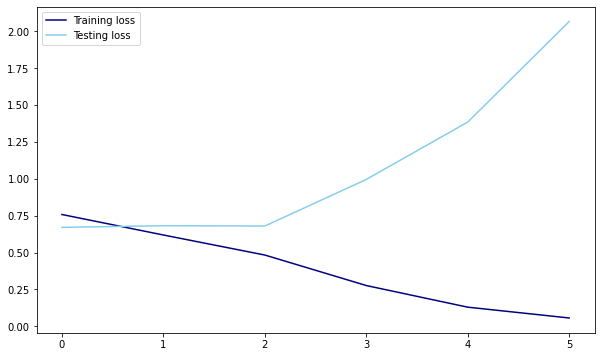

In [14]:
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Adding Additional Conv2D and MaxPooling 2D Layers with Dropout

In [10]:
model2 = Sequential()
model2.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [11]:
history2 = model2.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 31s 104ms/step - loss: 0.6814 - accuracy: 0.5656 - val_loss: 0.6800 - val_accuracy: 0.5464
Epoch 2/100
285/285 [==============================] - 29s 102ms/step - loss: 0.6649 - accuracy: 0.5897 - val_loss: 0.6514 - val_accuracy: 0.6256
Epoch 3/100
285/285 [==============================] - 29s 100ms/step - loss: 0.6500 - accuracy: 0.6149 - val_loss: 0.6500 - val_accuracy: 0.6325
Epoch 4/100
285/285 [==============================] - 28s 99ms/step - loss: 0.6375 - accuracy: 0.6338 - val_loss: 0.6633 - val_accuracy: 0.5904
Epoch 5/100
285/285 [==============================] - 29s 103ms/step - loss: 0.6177 - accuracy: 0.6548 - val_loss: 0.6386 - val_accuracy: 0.6344
Epoch 6/100
285/285 [==============================] - 28s 98ms/step - loss: 0.6017 - accuracy: 0.6734 - val_loss: 0.6626 - val_accuracy: 0.6129
Epoch 7/100
285/285 [==============================] - 34s 118ms/step - loss: 0.5797 - accuracy: 0.6924 - val_loss: 0.6395 - v

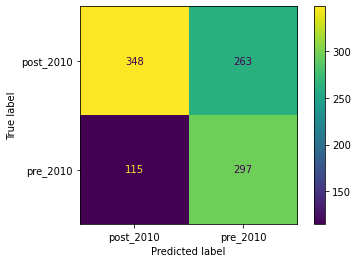

In [77]:
preds = model2.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(test_gen.class_indices.keys()));

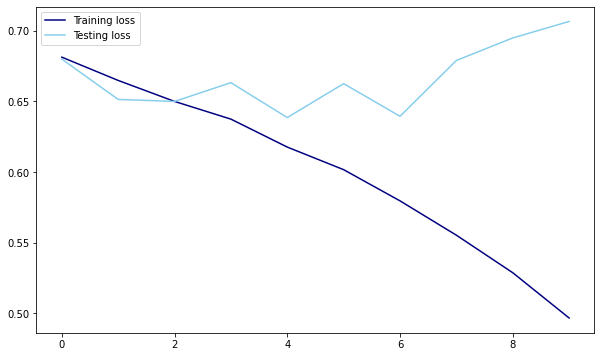

In [17]:
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Removing One Conv2D and MaxPooling 2D Layer

In [18]:
model3 = Sequential()
model3.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [19]:
history3 = model3.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 38s 132ms/step - loss: 0.6741 - accuracy: 0.5802 - val_loss: 0.6730 - val_accuracy: 0.5621
Epoch 2/100
285/285 [==============================] - 39s 135ms/step - loss: 0.6503 - accuracy: 0.6209 - val_loss: 0.6491 - val_accuracy: 0.6383
Epoch 3/100
285/285 [==============================] - 33s 114ms/step - loss: 0.6282 - accuracy: 0.6496 - val_loss: 0.6426 - val_accuracy: 0.6413
Epoch 4/100
285/285 [==============================] - 32s 112ms/step - loss: 0.5971 - accuracy: 0.6794 - val_loss: 0.6337 - val_accuracy: 0.6491
Epoch 5/100
285/285 [==============================] - 28s 98ms/step - loss: 0.5554 - accuracy: 0.7135 - val_loss: 0.6422 - val_accuracy: 0.6579
Epoch 6/100
285/285 [==============================] - 29s 103ms/step - loss: 0.5124 - accuracy: 0.7488 - val_loss: 0.6571 - val_accuracy: 0.6276
Epoch 7/100
285/285 [==============================] - 28s 99ms/step - loss: 0.4661 - accuracy: 0.7818 - val_loss: 0.6784 - v

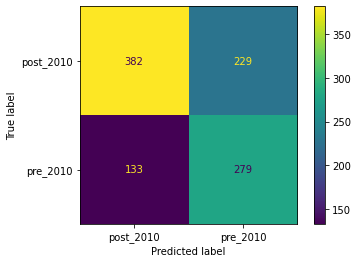

In [76]:
preds = model3.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(test_gen.class_indices.keys()));

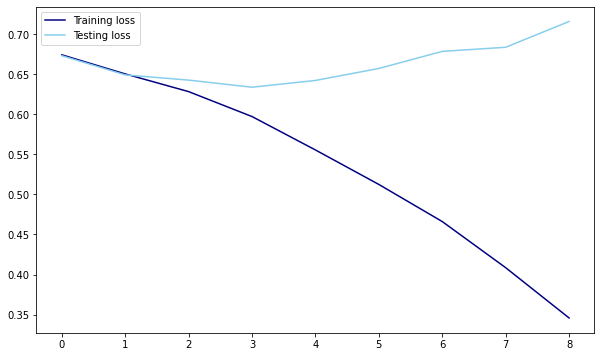

In [21]:
train_loss = history3.history['loss']
test_loss = history3.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### EfficientNet

In [22]:
eff_train_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)
eff_test_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)

In [23]:
eff_aug_train = eff_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(224,224)
)

eff_aug_test = eff_test_gen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 9117 validated image filenames belonging to 2 classes.
Found 1023 validated image filenames belonging to 2 classes.


In [24]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(eff_aug_train.classes), 
            y = eff_aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [25]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [26]:
effnet.trainable = False

In [27]:
model4 = Sequential()
model4.add(effnet)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='bce',
    metrics = ['accuracy']
)

In [28]:
history4 = model4.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 135s 445ms/step - loss: 0.6667 - accuracy: 0.5936 - val_loss: 0.6569 - val_accuracy: 0.6178
Epoch 2/100
285/285 [==============================] - 124s 436ms/step - loss: 0.6299 - accuracy: 0.6520 - val_loss: 0.6631 - val_accuracy: 0.6119
Epoch 3/100
285/285 [==============================] - 124s 435ms/step - loss: 0.6111 - accuracy: 0.6633 - val_loss: 0.6445 - val_accuracy: 0.6510
Epoch 4/100
285/285 [==============================] - 123s 432ms/step - loss: 0.6037 - accuracy: 0.6688 - val_loss: 0.6349 - val_accuracy: 0.6500
Epoch 5/100
285/285 [==============================] - 122s 428ms/step - loss: 0.5943 - accuracy: 0.6847 - val_loss: 0.6364 - val_accuracy: 0.6442
Epoch 6/100
285/285 [==============================] - 124s 435ms/step - loss: 0.5856 - accuracy: 0.6861 - val_loss: 0.6267 - val_accuracy: 0.6491
Epoch 7/100
285/285 [==============================] - 124s 434ms/step - loss: 0.5794 - accuracy: 0.6929 - val_loss: 0

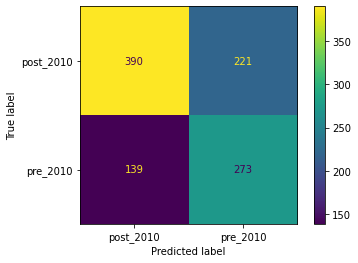

In [75]:
preds = model4.predict(eff_aug_test)

ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(eff_aug_test.class_indices.keys()));

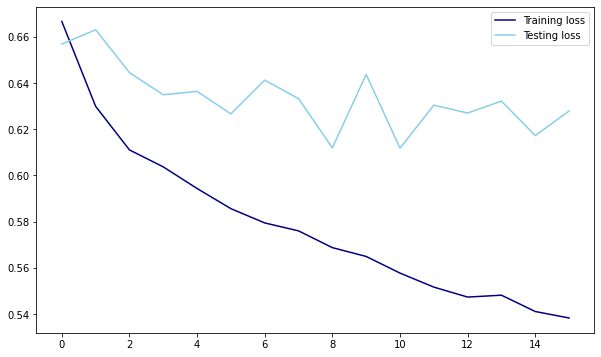

In [30]:
train_loss = history4.history['loss']
test_loss = history4.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### EffNet - Changing Learning Rate

In [31]:
model5 = Sequential()
model5.add(effnet)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='bce',
    metrics = ['accuracy']
)

In [32]:
history5 = model5.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 131s 436ms/step - loss: 0.6403 - accuracy: 0.6288 - val_loss: 0.6273 - val_accuracy: 0.6540
Epoch 2/100
285/285 [==============================] - 122s 427ms/step - loss: 0.6046 - accuracy: 0.6656 - val_loss: 0.6455 - val_accuracy: 0.6256
Epoch 3/100
285/285 [==============================] - 122s 427ms/step - loss: 0.5761 - accuracy: 0.6904 - val_loss: 0.6168 - val_accuracy: 0.6647
Epoch 4/100
285/285 [==============================] - 121s 426ms/step - loss: 0.5585 - accuracy: 0.7080 - val_loss: 0.6273 - val_accuracy: 0.6657
Epoch 5/100
285/285 [==============================] - 122s 428ms/step - loss: 0.5411 - accuracy: 0.7229 - val_loss: 0.6328 - val_accuracy: 0.6608
Epoch 6/100
285/285 [==============================] - 123s 432ms/step - loss: 0.5214 - accuracy: 0.7389 - val_loss: 0.6366 - val_accuracy: 0.6569
Epoch 7/100
285/285 [==============================] - 123s 433ms/step - loss: 0.4963 - accuracy: 0.7547 - val_loss: 0

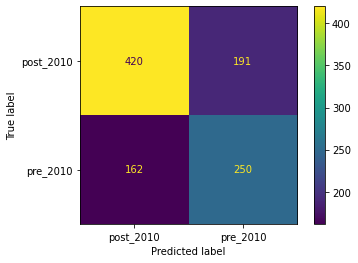

In [74]:
preds = model5.predict(eff_aug_test)

ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(eff_aug_test.class_indices.keys()));

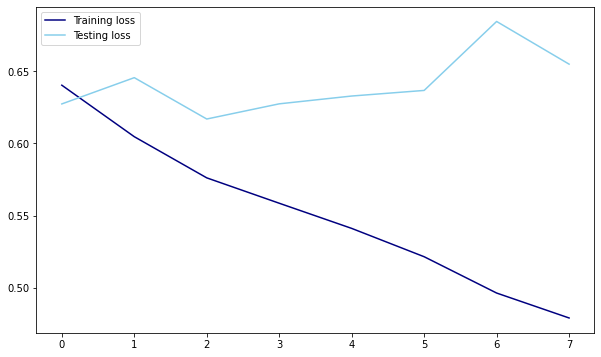

In [34]:
train_loss = history5.history['loss']
test_loss = history5.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Data Augmentation

In [35]:
aug_train_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

datagen = ImageDataGenerator(rescale=1/255)

In [36]:
aug_train = aug_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(256,256)
)

aug_test = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='post_2010',
    class_mode='binary',
    target_size=(256,256),
    shuffle=False
)

Found 9117 validated image filenames belonging to 2 classes.
Found 1023 validated image filenames belonging to 2 classes.


In [37]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(aug_train.classes), 
            y = aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [38]:
model6 = Sequential()
model6.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(64,(3,3),activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())
model6.add(Dense(128,activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(1,activation='sigmoid'))

model6.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [39]:
history6 = model6.fit(
    aug_train,
    class_weight=train_class_weights,
    validation_data=aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 145s 505ms/step - loss: 0.7073 - accuracy: 0.5210 - val_loss: 0.6657 - val_accuracy: 0.6080
Epoch 2/100
285/285 [==============================] - 145s 507ms/step - loss: 0.6843 - accuracy: 0.5451 - val_loss: 0.6710 - val_accuracy: 0.5660
Epoch 3/100
285/285 [==============================] - 145s 509ms/step - loss: 0.6822 - accuracy: 0.5585 - val_loss: 0.6646 - val_accuracy: 0.6012
Epoch 4/100
285/285 [==============================] - 145s 510ms/step - loss: 0.6775 - accuracy: 0.5796 - val_loss: 0.6550 - val_accuracy: 0.6188
Epoch 5/100
285/285 [==============================] - 145s 507ms/step - loss: 0.6756 - accuracy: 0.5878 - val_loss: 0.6642 - val_accuracy: 0.5973
Epoch 6/100
285/285 [==============================] - 145s 508ms/step - loss: 0.6728 - accuracy: 0.5788 - val_loss: 0.6546 - val_accuracy: 0.6139
Epoch 7/100
285/285 [==============================] - 146s 513ms/step - loss: 0.6709 - accuracy: 0.5958 - val_loss: 0

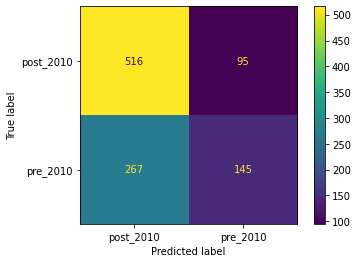

In [73]:
preds = model6.predict(aug_test)

ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(aug_test.class_indices.keys()));

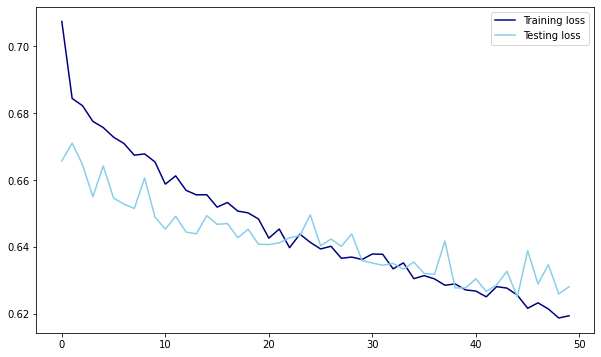

In [41]:
train_loss = history6.history['loss']
test_loss = history6.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Another CNN Model - Altering Parameters

In [42]:
model7 = Sequential()
model7.add(Conv2D(128,(4,4),activation='relu',input_shape=(256,256,3)))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(16,(4,4),activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(32,(3,3),activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(128,(4,4),activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Flatten())
model7.add(Dense(32,activation='relu'))
model7.add(Dropout(0.1))
model7.add(Dense(1,activation='sigmoid'))

model7.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'bce',
    metrics = ['accuracy']
)

In [43]:
history7 = model7.fit(
    train_gen,
    class_weight=train_class_weights,
    validation_data=test_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 31s 106ms/step - loss: 0.6812 - accuracy: 0.5853 - val_loss: 0.6817 - val_accuracy: 0.5523
Epoch 2/100
285/285 [==============================] - 30s 107ms/step - loss: 0.6597 - accuracy: 0.6005 - val_loss: 0.6510 - val_accuracy: 0.6276
Epoch 3/100
285/285 [==============================] - 30s 106ms/step - loss: 0.6500 - accuracy: 0.6139 - val_loss: 0.6760 - val_accuracy: 0.5846
Epoch 4/100
285/285 [==============================] - 31s 110ms/step - loss: 0.6414 - accuracy: 0.6249 - val_loss: 0.6585 - val_accuracy: 0.6051
Epoch 5/100
285/285 [==============================] - 30s 106ms/step - loss: 0.6304 - accuracy: 0.6411 - val_loss: 0.6402 - val_accuracy: 0.6276
Epoch 6/100
285/285 [==============================] - 30s 106ms/step - loss: 0.6198 - accuracy: 0.6502 - val_loss: 0.6424 - val_accuracy: 0.6315
Epoch 7/100
285/285 [==============================] - 30s 106ms/step - loss: 0.6095 - accuracy: 0.6607 - val_loss: 0.6388 -

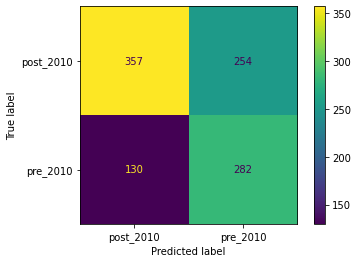

In [72]:
preds = model7.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.where(preds > 0.5, 1, 0), 
    display_labels=list(test_gen.class_indices.keys()));

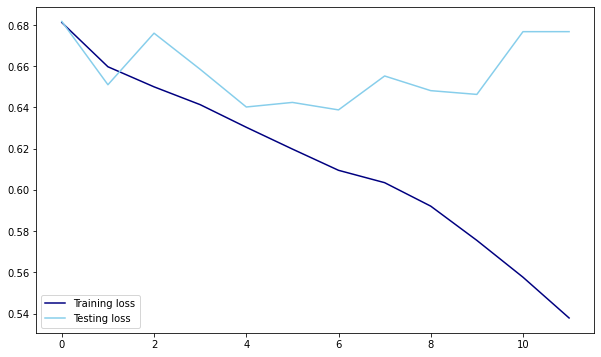

In [45]:
train_loss = history7.history['loss']
test_loss = history7.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();